In [15]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from lmfit.models import ExpressionModel
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from livelossplot import PlotLossesKeras
import lmfit

TARGET = 'fc'

# print(tf.__version__)
np.set_printoptions(precision=3, suppress=True)

In [134]:
df = pd.read_csv('https://raw.githubusercontent.com/mzakharo/tubby/main/orpv3.csv').dropna()

df_orig = df.copy()
df

,orp,ph,ppm
0,580.909091,8.500000,0.2
1,600.000000,8.400000,0.2
2,650.000000,8.109091,0.2
3,665.000000,8.000000,0.2
4,700.000000,7.700000,0.2
...,...,...,...
75,810.000000,8.000000,10.0
76,846.000000,7.500000,10.0
77,850.000000,7.450000,10.0
78,871.000000,7.000000,10.0


In [136]:
#Vlads data engineering
i = 80
df.loc[i] = { 'ppm': 0.2, 'orp': 500, 'ph': 8.7}
i += 1
df.loc[i] = { 'ppm': 0.6, 'orp': 500, 'ph': 8.85}
i += 1
df.loc[i] = { 'ppm': 1.0, 'orp': 500, 'ph': 9.0}
i += 1
df.loc[i] = { 'ppm': 2.0, 'orp': 500, 'ph': 9.2}
i += 1
df.loc[i] = { 'ppm': 3.0, 'orp': 500, 'ph': 9.3}
i += 1
df.loc[i] = { 'ppm': 5.0, 'orp': 500, 'ph': 9.4}
i += 1
df.loc[i] = { 'ppm': 7.0, 'orp': 500, 'ph': 9.5}
i += 1
df.loc[i] = { 'ppm': 10.0, 'orp': 500, 'ph': 9.6}

In [9]:
df

,orp,ph,ppm
0,580.909091,8.500000,0.2
1,600.000000,8.400000,0.2
2,650.000000,8.109091,0.2
3,665.000000,8.000000,0.2
4,700.000000,7.700000,0.2
...,...,...,...
83,500.000000,9.200000,2.0
84,500.000000,9.300000,3.0
85,500.000000,9.400000,5.0
86,500.000000,9.500000,7.0


[[Model]]
    Model(skewed_voigt)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 537
    # data points      = 10
    # variables        = 4
    chi-square         = 0.00107207
    reduced chi-square = 1.7868e-04
    Akaike info crit   = -83.4075157
    Bayesian info crit = -82.1971754
    R-squared          = 0.99976838
[[Variables]]
    amplitude:  22169.5373 +/- 5936.74170 (26.78%) (init = 660)
    center:     914.485354 +/- 6.63064026 (0.73%) (init = 615.9848)
    sigma:      986.712589 +/- 298.990851 (30.30%) (init = 100)
    skew:      -4.37815715 +/- 1.64086425 (37.48%) (init = 0)
    gamma:      986.712589 +/- 298.990851 (30.30%) == 'sigma'
[[Correlations]] (unreported correlations are < 0.100)
    C(amplitude, sigma)  = +0.9999
    C(sigma, skew)       = -0.9989
    C(amplitude, skew)   = -0.9983
    C(amplitude, center) = +0.9772
    C(center, sigma)     = +0.9757
    C(center, skew)      = -0.9666
[[Model]]
    Model(skewed_voigt)
[[Fit Statistic

dict_keys([0.2, 0.6, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0])

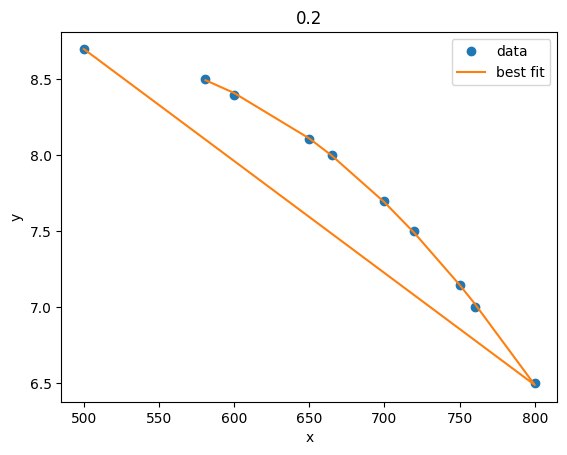

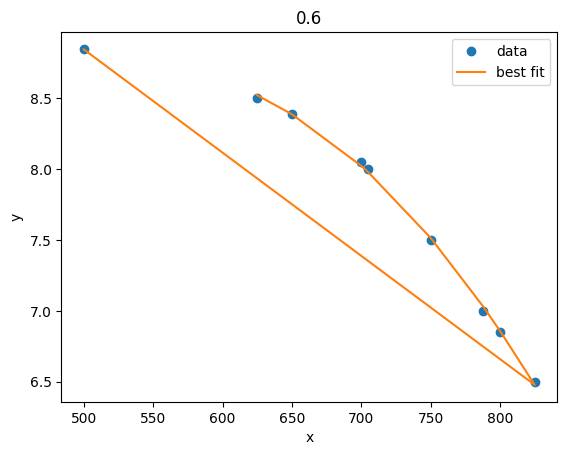

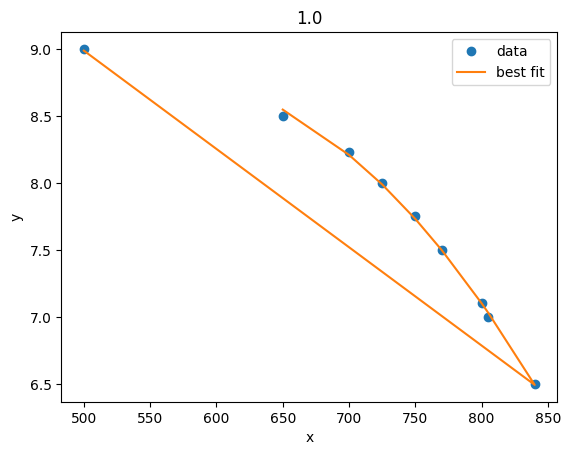

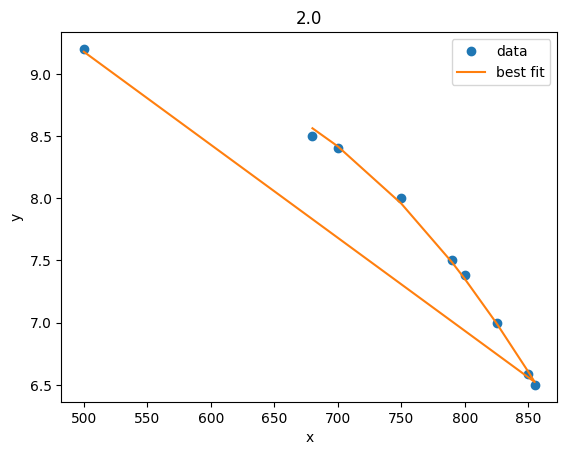

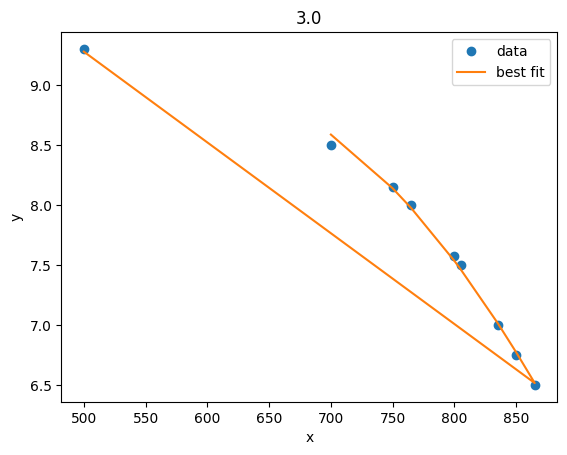

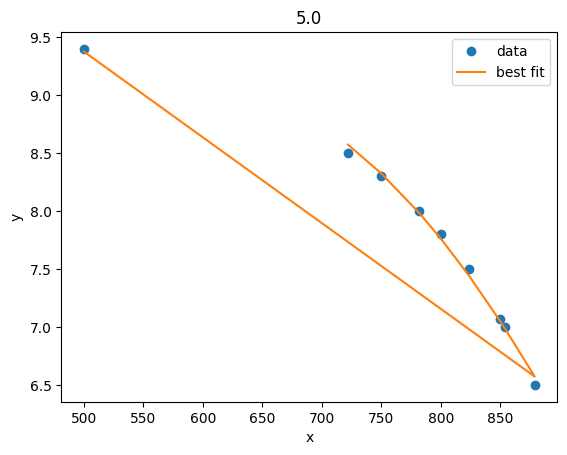

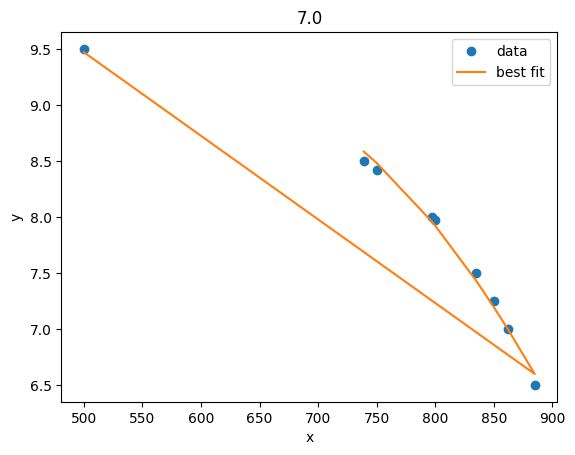

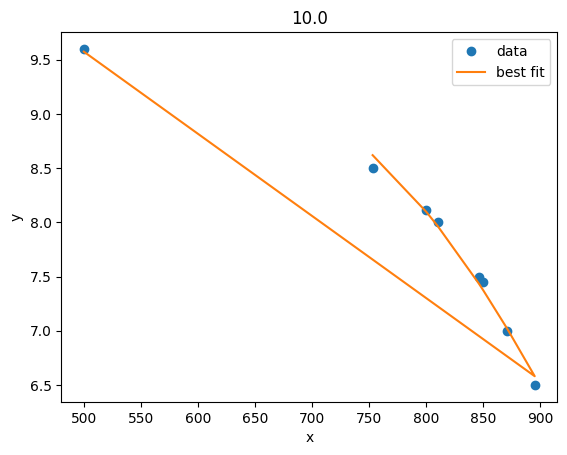

In [68]:

ppms = df['ppm'].unique()
models = {}
for ppm in ppms:    
    data =df.loc[df['ppm'] == ppm]
    xdata = data['orp'].to_numpy()
    ydata = data['ph'].to_numpy()
    # lmodel = lmfit.models.PolynomialModel(degree=2)
    # lmodel = ExpressionModel('off + amp * exp(-(x+beta)/x0) ')
    lmodel = lmfit.models.SkewedVoigtModel()
    params = lmodel.guess(ydata, x=xdata)
    # print(params)
    # break
    fit = lmodel.fit(ydata, params, x=xdata)    
    models[ppm] = fit
    print(fit.fit_report())
    plt.figure() 
    fit.plot_fit(title=str(ppm))
models.keys()

In [69]:
sample_xs = np.linspace( 500, 900, 100 )
sample_xs.shape

(100,)

0.2
0.6
1.0
2.0
3.0
5.0
7.0
10.0


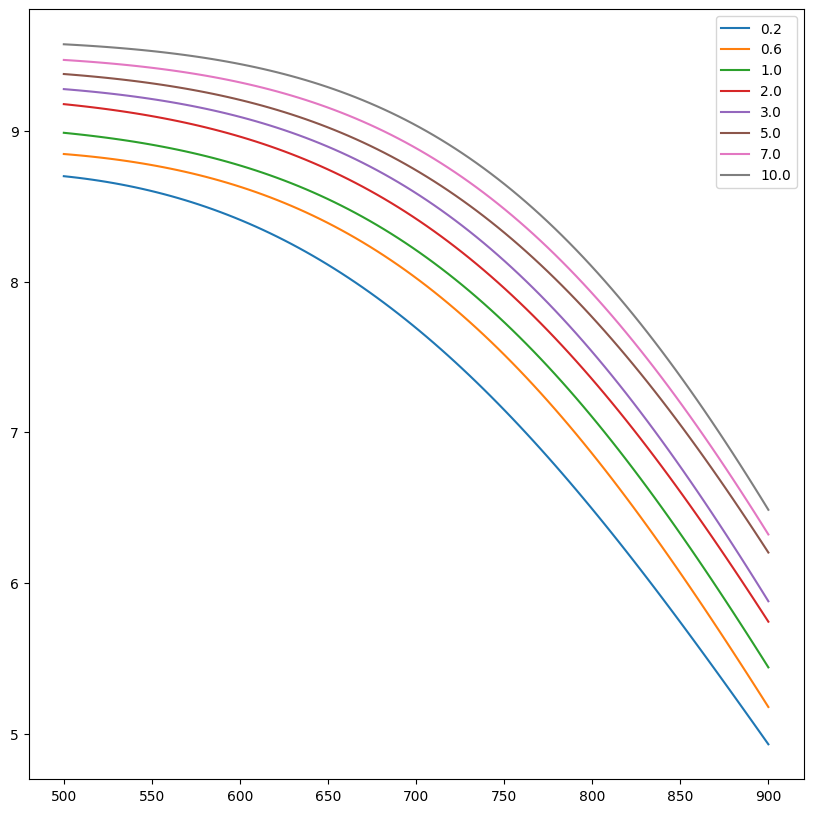

In [70]:
plt.figure(figsize=(10,10))
for key, mod in models.items():
    print(key)
    plt.plot(sample_xs, mod.eval(x=sample_xs), label=key)
plt.legend()
plt.show()

In [71]:
vs = []
for fc, fit in models.items():
    for orp in range(500, 900, 1):
        ph = fit.eval(x=orp)        
        vs.append((orp, ph, fc))
dataset = pd.DataFrame(vs, columns= ('orp', 'ph', 'fc'))
dataset.describe()

,orp,ph,fc
count,3200.000000,3200.000000,3200.000000
mean,699.500000,8.113461,3.600000
std,115.487739,1.082073,3.254737
min,500.000000,4.945886,0.200000
25%,599.750000,7.379919,0.900000
50%,699.500000,8.426026,2.500000
75%,799.250000,8.972838,5.500000
max,899.000000,9.574807,10.000000


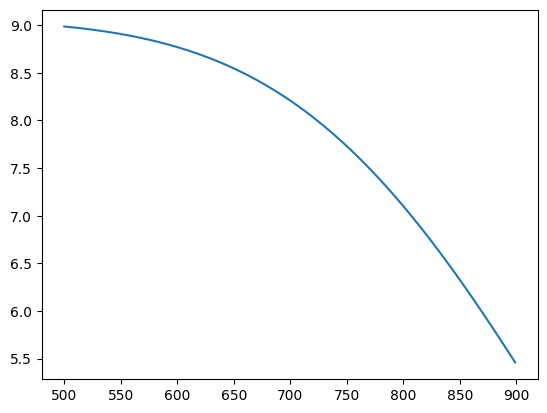

In [81]:
x = dataset[ dataset['fc'] == 1.0 ]['orp']
y = dataset[ dataset['fc'] == 1.0 ]['ph']
plt.figure()
plt.plot(x, y , label='1.0')

           mean         std
orp  699.328125  115.416077
ph     8.112657    1.082508
fc     3.597344    3.268267


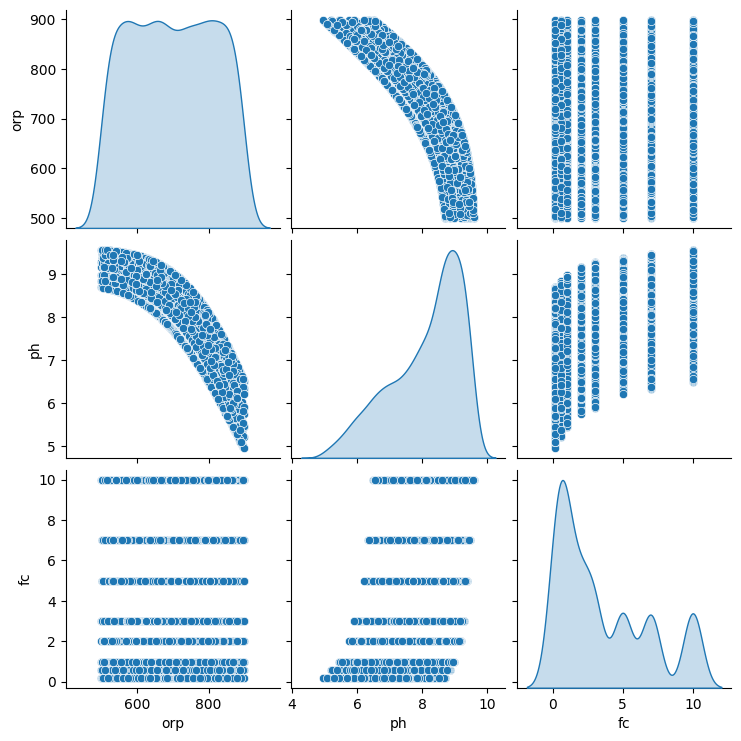

In [82]:
train_dataset = dataset.sample(frac=0.8)#, random_state=0)
test_dataset = dataset.drop(train_dataset.index) #dataset_orig # dataset.drop(train_dataset.index)

train_features = train_dataset.copy()
train_labels = train_features.pop(TARGET)

test_features = test_dataset.copy()
test_labels = test_features.pop(TARGET)

print(train_dataset.describe().transpose()[['mean', 'std']])
sns.pairplot(train_dataset, diag_kind='kde')

inorm = tf.keras.layers.Normalization(axis=-1, input_shape=[2, ])
inorm.adapt(np.array(train_features))
onorm = tf.keras.layers.Normalization(axis=-1, invert=True)
onorm.adapt(train_labels)

In [119]:
checkpoint_filepath = 'checkpoint.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

def build_and_compile_model(inorm, onorm):
  model = keras.Sequential([
      inorm,
      layers.Dense(5, activation='elu'),
      layers.Dense(20, activation='elu'),
      layers.Dense(20, activation='elu'),
      layers.Dense(5, activation='elu'),
      layers.Dense(1), 
      onorm,
  ])
  model.compile(loss='mean_squared_error', optimizer='adam')
  return model
model = build_and_compile_model(inorm, onorm)
model.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_6 (Normalizat  (None, 2)                5         
 ion)                                                            
                                                                 
 dense_47 (Dense)            (None, 5)                 15        
                                                                 
 dense_48 (Dense)            (None, 20)                120       
                                                                 
 dense_49 (Dense)            (None, 20)                420       
                                                                 
 dense_50 (Dense)            (None, 5)                 105       
                                                                 
 dense_51 (Dense)            (None, 1)                 6         
                                                     

In [120]:
history = model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=1, epochs=300, callbacks=[PlotLossesKeras(), model_checkpoint_callback])
print('mse:', model.evaluate(test_features, test_labels, verbose=0))

KeyboardInterrupt: 

<Axes: xlabel='fc'>

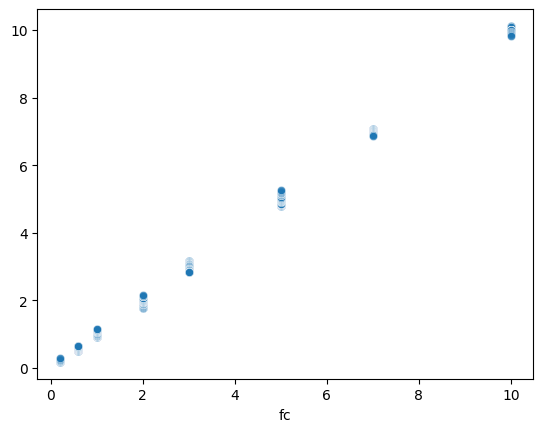

In [121]:
fmodel = checkpoint_filepath
#fmodel = 'model_fc.h5'

model = keras.models.load_model(fmodel, compile=False)
model.layers[-1].invert = True #Bug in Keras https://github.com/keras-team/keras/issues/17556


y = model.predict(test_features, verbose=0)
y = pd.DataFrame(y)[0]
sns.scatterplot(x=test_labels, y=y.to_numpy(), alpha=0.7)

<Axes: xlabel='fc'>

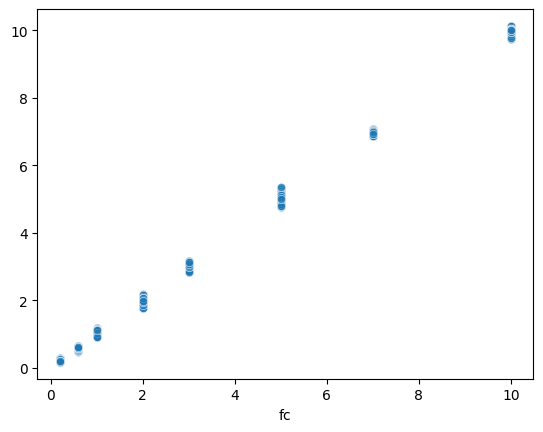

In [145]:

y = model.predict(train_features, verbose=0)
y = pd.DataFrame(y)[0]
sns.scatterplot(x=train_labels, y=y.to_numpy(), alpha=0.7)

In [41]:
model.save(f'model_{TARGET}.h5')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
with open(f'model_{TARGET}.tflite', "wb") as f:
  f.write(tflite_model)
print('done')

INFO:tensorflow:Assets written to: C:\Users\user\AppData\Local\Temp\tmp59rn3hc9\assets
done


In [185]:
p0 = 745
p1 = 7.2
print(p0, p1)
v = model.predict([(p0, p1)], verbose=0)[0][0]
print('output: ', v, v * 2.25)

745 7.2
output:  0.18952703 0.42643582820892334


           orp
0   580.909091
1   600.000000
2   650.000000
3   665.000000
4   700.000000
5   720.000000
6   750.000000
7   760.000000
8   800.000000
80  500.000000


C:\Users\user\AppData\Local\Temp\ipykernel_10072\2417741840.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['pred'] = model.predict(x[['orp', 'ph']].to_numpy(), verbose=0)


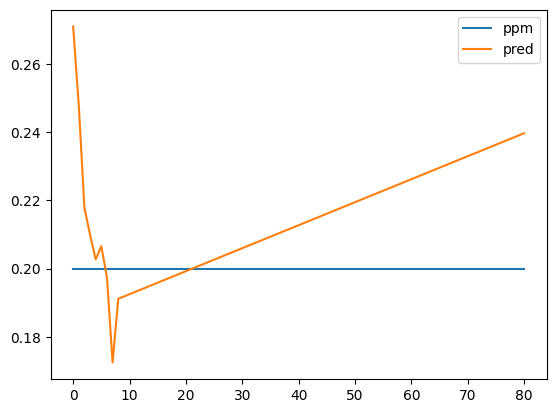

In [144]:
ppm = 0.2
x =df.loc[df['ppm'] == ppm]
print(x[['orp']])
x['pred'] = model.predict(x[['orp', 'ph']].to_numpy(), verbose=0)
x.plot( y=["ppm", "pred"]);

[[500.      8.   ]
 [504.04    8.   ]
 [508.081   8.   ]
 [512.121   8.   ]
 [516.162   8.   ]
 [520.202   8.   ]
 [524.242   8.   ]
 [528.283   8.   ]
 [532.323   8.   ]
 [536.364   8.   ]
 [540.404   8.   ]
 [544.444   8.   ]
 [548.485   8.   ]
 [552.525   8.   ]
 [556.566   8.   ]
 [560.606   8.   ]
 [564.646   8.   ]
 [568.687   8.   ]
 [572.727   8.   ]
 [576.768   8.   ]
 [580.808   8.   ]
 [584.848   8.   ]
 [588.889   8.   ]
 [592.929   8.   ]
 [596.97    8.   ]
 [601.01    8.   ]
 [605.051   8.   ]
 [609.091   8.   ]
 [613.131   8.   ]
 [617.172   8.   ]
 [621.212   8.   ]
 [625.253   8.   ]
 [629.293   8.   ]
 [633.333   8.   ]
 [637.374   8.   ]
 [641.414   8.   ]
 [645.455   8.   ]
 [649.495   8.   ]
 [653.535   8.   ]
 [657.576   8.   ]
 [661.616   8.   ]
 [665.657   8.   ]
 [669.697   8.   ]
 [673.737   8.   ]
 [677.778   8.   ]
 [681.818   8.   ]
 [685.859   8.   ]
 [689.899   8.   ]
 [693.939   8.   ]
 [697.98    8.   ]
 [702.02    8.   ]
 [706.061   8.   ]
 [710.101   

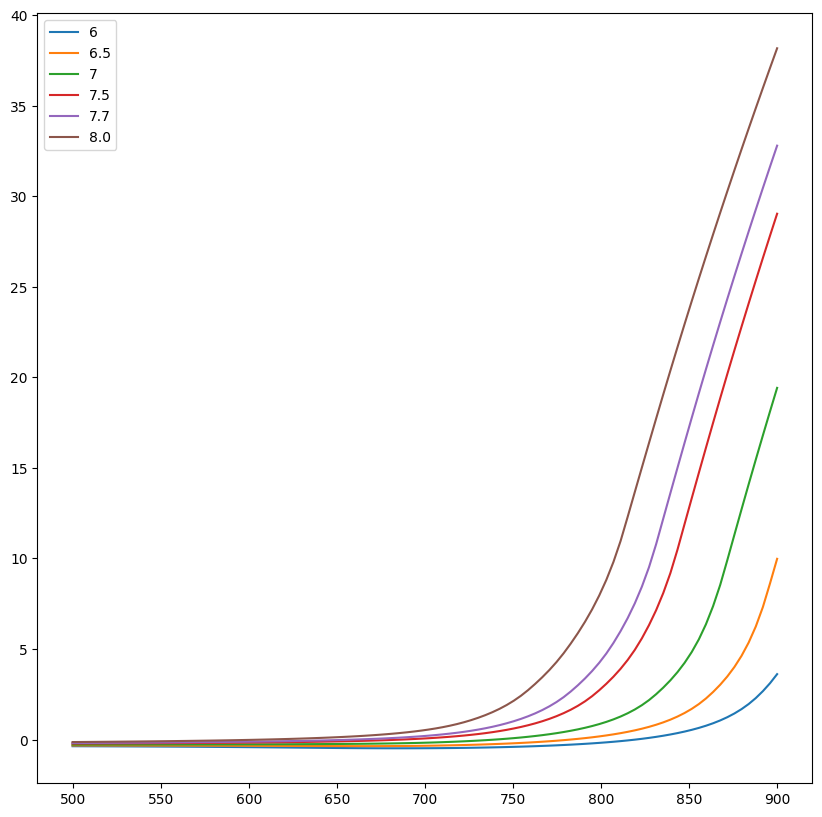

In [125]:
plt.figure(figsize=(10,10))

print(x)
for key in [6, 6.5, 7, 7.5, 7.7, 8.0]:
    ph = np.array([key] * len(sample_xs))
    x = np.array(list(zip(sample_xs,ph)))
    plt.plot(sample_xs, model.predict(x), label=key)
plt.legend()
plt.show()

In [173]:
phs = np.linspace(65, 85, 100) / 10
orps = np.linspace(550, 900, 100 )
vals =  pd.DataFrame()
for ph in phs:
    val = np.array([ph] * len(orps))
    x = np.array(list(zip(orps, val )))
    d = pd.DataFrame(x, columns= ['orp', 'ph'])
    d['ppm'] = model.predict(x, verbose=False)
    vals = pd.concat((vals, d))

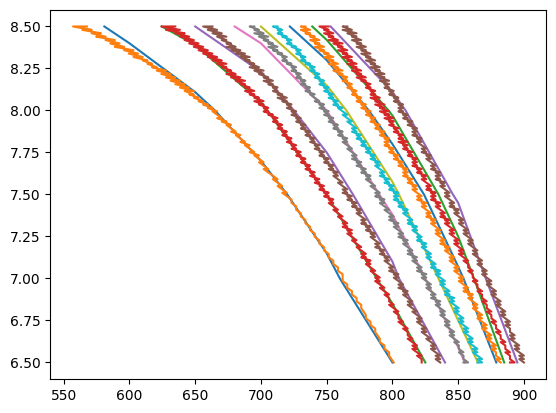

In [174]:
ppms = df['ppm'].unique()
models = {}
plt.figure()
for ppm in ppms:    
    data =df_orig.loc[df_orig['ppm'] == ppm]
    plt.plot(data[['orp']], data[[ 'ph']])
    predictions = vals[vals['ppm'].between(ppm*0.9, ppm*1.1, inclusive='neither')]
    plt.plot(predictions['orp'], predictions['ph'])
plt.show()
